VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training Deep Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# from tests.unit_tests import test_brick_1, test_brick_2, test_brick_3, test_brick_4, test_brick_5, test_brick_6
# from libs.dkf import DeepKalmanFilter, loss_function

In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


# Modèle

### Structure SSM (Single State Model pour variables latentes + VAE pour observations):

- $z_t$ variables latentes forment une chaîne de Markov, transition $p(z_t \vert z_{t-1})$
- $x_t$ observations, modèle $p_{\theta_x}(x_t \vert z_t)$
- NB : pas de commande/input $u_t$ ici

### Deep Kalman Filter :

\begin{align}
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
d_z(z_{t-1}) &= [ \mu_{\theta_z}(z_{t-1}), \sigma_{\theta_z}(z_{t-1}) ] \\
p_{\theta_x}(x_t \vert z_{t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_{t}), \text{diag}(\sigma_{\theta_x}^{2}(z_{t}))) \\
d_x(z_{t}) &= [ \mu_{\theta_x}(z_{t}), \sigma_{\theta_x}(z_{t}) ] \\
\end{align}

où $d_x, d_z$ sont des réseaux.

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
&= \prod_{t=1}^T p_{\theta} (z_t \vert z_{t-1}, x_{t:T} )
\end{align}

où la première écriture est l'application de la chain rule, et la deuxième est un résultat de D-séparation (latentes à dépendance Markovienne).

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{t-1}, x_{t:T})
\end{align}

On voit que l'inférence prend en compte les observations futures $x_{t:T}$ (comme le Kalman smoother par exemple)

# Implémentation de l'inférence

- **backward RNN** (dans les faits, un LSTM) pour encoder les $x_{t:T}$ par les hidden states $h_t$ : 

\begin{align}
h_t = \text{LSTM}(h_{t+1}, x_t)
\end{align}

- **combiner** (réseau MLP) pour aggréger $h_t$ et $z_{t-1}

\begin{align}
g_t = \text{Combiner}(h_t, z_{t-1})
\end{align}

- **Encoder** (réseau MLP) pour inférer les paramètres du posterior:

\begin{align}
e_z(g_t) &= [ \mu_\phi(g_t), \sigma_\phi(g_t)] \\
q_\phi(z_t \vert g_t) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t)))
\end{align}

NB : il existe d'autres formulations du posterior approximé $q_\phi$, qui peuvent faire intervenir un forward LSTM.

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation générique se simplifie dans le cas du DKF en :

\begin{align}
\mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T \mathbb{E}_{q_\phi(z_t \vert x_{1:T})} \log(p_{\theta_x}(x_t \vert z_t)) -
\sum_{t=1}^T \mathbb{E}_{q_\phi(z_{t-1} \vert x_{1:T})} \text{D}_{\text{KL}} \left[ q_\phi(z_t \vert z_{t-1}, x_{t:T}) \vert\vert 
p_{\theta_z}(z_t \vert z_{t-1}) \right]
\end{align}

Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align}

# Code

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 2 # Dimension of the latent space
H_DIM = 16 # Dimension of the hidden state of the LSTM network(s)
G_DIM = 2 # Dimension of the output of the combiner
INTERMEDIATE_LAYER_DIM = 16 # Dimension of the intermediate layers of the MLPs

### Briques de base

In [6]:
#--- brick 1 : backward LSTM -----------------------------

class BackwardLSTM(nn.Module):
    """
    Backward LSTM module.
    Creates a unidirectional LSTM, with num_layers layers, hidden state
    of dimension hidden_size, and input of dimension input_size.
    The LSTM is used to process the input sequence in reverse order.
    """
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(BackwardLSTM, self).__init__()
        
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size,   # dimension of the observation space
            hidden_size,  # dimension of the hidden state of the LSTM network
            num_layers=num_layers, # number of layers of the LSTM network
            batch_first=False, # using the default PyTorch LSTM implementation, expecting input shape (seq_len, batch, input_size)
            bidirectional=False # unidirectional LSTM to start with
            )

    def forward(self, x):
        """
        Forward pass of the backward LSTM module. The sequence x
        is reversed via a torch.flip operation, then passed through the LSTM.
        The output sequence is reversed again to get the final output.
        
        Args:
            x: input sequence
            shape (seq_len, batch, input_size)
        Returns:
            out: output sequence
            shape (seq_len, batch, hidden_size)
        """
        # Reverse the input sequence - axis 0 is the time axis here
        x_reversed = torch.flip(x, [0])
        # Pass through LSTM
        # using initial hidden state and cell state as zeros
        out, _ = self.lstm(x_reversed)
        # Reverse the output sequence
        out_reversed = torch.flip(out, [0])
        # return output shape (seq_len, batch, hidden_size)
        
        return out_reversed

In [7]:
#--- brick 2 : combiner -----------------------------
#
# this combines the latent variable at time t-1
# with the hidden state from the backward LSTM at time t,
# to compute a t
    # X_DIM = 1 # Dimension of the observation space
    # Z_DIM = 16 # Dimension of the latent space
    # H_DIM = 16 # Dimension of the hidden state of the LSTM network(s)
    # G_DIM = 8 # Dimension of the output of the combiner
    # INTERMEDIATE_LAYER_DIM = 16 # Dimension of the intermediate layers of the MLPsensor g at time t, that will be used
# to compute the parameters of the approximate posterior distribution
# of the latent variable
#

class CombinerMLP(nn.Module):
    """Combiner module. Takes the hidden state of the backward LSTM at time t
    and the (sampled) latent variable at time t-1, to compute a tensor g at time t,
    that will be used to compute the parameters of the approximate posterior
    distribution of the latent variable.
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, 
                 hidden_dim=H_DIM, 
                 output_dim=G_DIM,
                 layers_dim = None,  # list of layers dimensions, without the input dimnesion, without the output dimension
                 activation = 'tanh',
                 inter_dim = INTERMEDIATE_LAYER_DIM,
                 ):
        """Creates a combiner module, ie a MLP layer, to combine h_t (the output of the backward lstm at time t
        and (sampled) z_t-1, the latent variable at time t-1.
        The input_dimension is the sum of the latent dimension (dimension of z_t-1) and the hidden dimension
        (dimension of h_t).
        The output dimension is the dimension of the combiner output, which is a parameter.
        The list of intermediate layers is passed in the list layers_dim.
        The activation function is passed as a string, either 'tanh' or 'relu'. (default = 'tanh')
        
        Inputs:
            latent_dim : dimension of the latent space
            hidden_dim : dimension of the hidden state of the LSTM network
            output_dim : dimension of the combiner output
            layers_dim : list of layers dimensions, without the input dimension, without the output dimension
            activation : activation function (default = 'tanh')
            inter_dim : dimension of the intermediate layers (default = INTERMEDIATE_LAYER_DIM)
        """
        super(CombinerMLP, self).__init__()
        
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        self.inter_dim = inter_dim
        self.layers_dim = layers_dim
        
        if self.layers_dim is None:
            self.layers_dim = [self.inter_dim] * 2
        else:
            self.layers_dim = layers_dim
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(self.layers_dim):
            if i==0:  #first layer, latent_dim + hidden_dim => layers_dim[0]
                layers.append(nn.Linear(latent_dim + hidden_dim, dim))
            else:  # all other layers
                layers.append(nn.Linear(self.layers_dim[i-1], dim))
            layers.append(self.activation_fn)
        # last layer : layers_dim[-1] => output_dim
        layers.append(nn.Linear(self.layers_dim[-1], output_dim))
            
        # build the MLP
        self.mlp = nn.Sequential(*layers)
            
        
    def forward(self, h, z):
        """
        Forward pass of the combiner module.
        The use of the combiner module is sequential, so there is no seq_len dimension.
        
        Args:
            h: hidden state of the backward LSTM at time t
            shape (batch, hidden_dim)
            z: latent variable at time t-1
            shape (batch, latent_dim)
        Returns:
            g: tensor g at time t
            shape (batch, output_dim)
        """
        
        # Concatenate the hidden state and the latent variable on their dimension
        x = torch.cat((h, z), dim=-1) # shape (batch, hidden_dim + latent_dim)
        
        # Pass through MLP
        g = self.mlp(x) # output shape (batch, output_dim)
        
        return g     

In [8]:
#--- brick 3 : Encoder -----------------------------
#
# This computes the parameters of the approximate posterior distribution
# of the latent vatiable at time t.
# The approximate posterior distribution is a Gaussian distribution,
# we use a MLP to compute the mean and the log of the variance.
#

class EncoderMLP(nn.Module):
    """Encoder module. 
    Computes the parameters of the approximate posterior
    distribution of the latent variable at time t. 
    The approximate posterior distribution is a Gaussian distribution, we use a MLP to compute the mean
    and the log of the variance.
    The input variables are g_t (the output of the combiner module at time t) and
    z_t-1 (the -sampled- latent variable at time t-1).
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, # Dimension of the latent space
                 combiner_dim=G_DIM, # Dimension of the combiner output
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 layers_dim = None, # Dimension of the MLP layers (without inout nor output)
                 activation = 'tanh', # Activation function
    ):
        """Creates the encoder module.
        This is a MLP, that takes as input the combiner output g_t (combining h_t and z_t-1).
        The input dimension is the combiner dimension.
        The output dimension is the 2 * dimension of the latent space (mean, and log variance).
        The list of intermediate layers is passed in the list layers_dim.
        The activation function is passed as a string, either 'tanh' or 'relu'. (default = 'tanh')
        
        Inputs:
            latent_dim : dimension of the latent space
            combiner_dim : dimension of the combiner output
            inter_dim : dimension of the intermediate layers (default = INTERMEDIATE_LAYER_DIM)
            layers_dim : list of layers dimensions, without the input dimension, without the output dimension
            activation : activation function (default = 'tanh')
        """
        super(EncoderMLP, self).__init__()
        
        self.latent_dim = latent_dim
        self.combiner_dim = combiner_dim
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        self.inter_dim = inter_dim
        
        if layers_dim is None:
            self.layers_dim = [self.inter_dim] * 2
        else:
            self.layers_dim = layers_dim
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(self.layers_dim):
            if i==0:
                layers.append(nn.Linear(combiner_dim, dim))
            else:
                layers.append(nn.Linear(self.layers_dim[i-1], dim))
            layers.append(self.activation_fn)
            
        # last layer is linear, no activation
        layers.append(nn.Linear(self.layers_dim[-1], 2 * latent_dim)) 
                    
        # build the MLP
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, g):
        """
        Forward pass of the encoder module.
        Takes g_t (the output of the combiner module at time t) as input, returns the parameters of the
        approximate posterior distribution of the latent variable at time t.
        The encoder module is used sequentially, so there is no seq_len dimension.
        The output is a tuple (mu, logvar), where mu is the mean of the approximate posterior distribution
        and logvar is the log of the variance of the approximate posterior distribution.
        
        Args:
            g: tensor g at time t
            shape (batch, combiner_dim)
            
        Returns:
            mu: mean of the approximate posterior distribution
            shape (batch, latent_dim)
            logvar: log of the variance of the approximate posterior distribution
            shape (batch, latent_dim)
        """
        
        # Pass through MLP
        out = self.mlp(g)
        
        # Split the output into mean and log variance
        # each with shape (batch, latent_dim)
        mu, logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        
        return mu, logvar

In [9]:
#--- brick 4 : Latent Space Transition -----------------------------       
#
# This computes the parameters of the transition distribution
# of the latent variable at time t. Ie the prior distribution, 
# before inference.
# The transition distribution is a Gaussian distribution,
# we use a MLP to compute the mean and the log of the variance.
#

class LatentSpaceTransitionMLP(nn.Module):
    """Latent space transition module. 
    Computes the parameters of the transition distribution of the latent variable at time t (ie "prior").
    The transition distribution is a Gaussian distribution, we use a MLP to compute the mean
    and the log of the variance.
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, # Dimension of the latent space
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 layers_dim = None, # Dimension of the MLP layers
                 activation = 'tanh', # Activation function
    ):
        """Creates the latent space transition MLP.
        This is a MLP, that takes as input the -sampled- lagged latent variable z_t-1,
        and computes the parameters of the transition distribution p(z_t|z_{t-1}).
        The input dimension is the latent dimension.
        The output dimension is the 2 * dimension of the latent space (mean, and log variance).
        The list of intermediate layers is passed in the list layers_dim.
        The activation function is passed as a string, either 'tanh' or 'relu'. (default = 'tanh')
        Inputs:
            latent_dim : dimension of the latent space
            inter_dim : dimension of the intermediate layers (default = INTERMEDIATE_LAYER_DIM)
            layers_dim : list of layers dimensions, without the input dimension, without the output dimension
            activation : activation function (default = 'tanh')
        """
        super(LatentSpaceTransitionMLP, self).__init__()
        
        self.latent_dim = latent_dim
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        self.inter_dim = inter_dim
        
        if layers_dim is None:
            layers_dim = [self.inter_dim]
        self.layers_dim = layers_dim
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(self.layers_dim):
            if i==0:
                layers.append(nn.Linear(self.latent_dim, dim))
            else:
                layers.append(nn.Linear(self.layers_dim[i-1], dim))
            layers.append(self.activation_fn)
            
        # last layer is linear, no activation
        layers.append(nn.Linear(self.layers_dim[-1], 2 * self.latent_dim)) 
                    
        # build the MLP
        self.mlp = nn.Sequential(*layers)
               
    def forward(self, z):
        """
        Forward pass of the latent space transition module.
        This takes as input a whole set of lagged -sampled- latent variables z_t-1,
        and computes the parameters of the transition distribution p(z_t|z_{t-1}) for each time step t.
        
        Args:
            z: latent variables lagged(set of latent variables at time t-1)
            shape (seq_len, batch, latent_dim)
            
        Returns:
            mu: means of the transition distribution
            shape (seq_len, batch, latent_dim)
            logvar: log of the variances of the transition distribution
            shape (seq_len, batch, latent_dim)
        """
        
        # Pass through MLP
        out = self.mlp(z)
        
        # Split the output into mean and log variance
        # each with shape (batch, latent_dim)
        mu, logvar = out[:, :, :self.latent_dim], out[:, :, self.latent_dim:]
        
        return mu, logvar

In [10]:
#--- brick 5 : Decoder (ie Observation Model) -----------------------------
#
# This computes the parameters of the distribution of 
# the observed variable 'x', given the latent variable 'z'.
# The distribution is a Gaussian distribution,
# we use a MLP to compute the mean and the log of the variance.
#

class DecoderMLP(nn.Module):
    """Decoder module. Computes the parameters of the distribution of the
    observed variable 'x', given the latent variable 'z' sampled from the approximate
    posterior distribution.
    The distribution is a Gaussian distribution, we use a MLP to compute the mean and the log of
    the variance.   
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, # Dimension of the latent space
                 observation_dim=X_DIM, # Dimension of the observation space
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 layers_dim = None, # Dimension of the MLP layers
                 activation = 'tanh', # Activation function
    ):
        """Creates the decoder module.
        This is a MLP, that takes as input a set of -sampled- latent variables z_t,
        and computes the parameters of the distribution of the observed variable 'x'.
        The input dimension is the latent dimension.
        The output dimension is the 2 * dimension of the observation space (mean, and log variance).
        The list of intermediate layers is passed in the list layers_dim.
        The activation function is passed as a string, either 'tanh' or 'relu'. (default = 'tanh')
        
        Inputs:
            latent_dim : dimension of the latent space
            observation_dim : dimension of the observation space
            inter_dim : dimension of the intermediate layers (default = INTERMEDIATE_LAYER_DIM)
            layers_dim : list of layers dimensions, without the input dimension, without the output dimension
            activation : activation function (default = 'tanh')
        """
        super(DecoderMLP, self).__init__()
        
        self.latent_dim = latent_dim
        self.observation_dim = observation_dim
        self.inter_dim = inter_dim
        
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        
        if layers_dim is None:
            layers_dim = [self.inter_dim] # one layer per default
        self.layers_dim = layers_dim
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(self.layers_dim):
            if i==0:
                layers.append(nn.Linear(self.latent_dim, dim))
            else:
                layers.append(nn.Linear(self.layers_dim[i-1], dim))
            layers.append(self.activation_fn)
            
        # last layer is linear, no activation
        layers.append(nn.Linear(self.layers_dim[-1], 2 * self.observation_dim)) 
                    
        # build the MLP
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, z):
        """
        Forward pass of the decoder module.
        This takes as input the set of -sampled- latent variables z_t, and 
        computes the set of parameters of the distribution of the observed variable 'x'.
        The decoder module is used after the sequential loop, so there is a seq_len dimension.
        
        Args:
            z: latent variable at time t
            shape (seq_len, batch, latent_dim)
        Returns:
            mu: means of the distribution of the observed variable
            shape (seq_len, batch, observation_dim)
            logvar: log of the variances of the distribution of the observed variable
            shape (seq_len, batch, observation_dim)
        """
        # Pass through MLP
        out = self.mlp(z)
        
        # Split the output into mean and log variance
        # each with shape (batch, observation_dim)
        mu, logvar = out[:, :, :self.observation_dim], out[:, :, self.observation_dim:]
        
        return mu, logvar

In [11]:
# --- brick 6 : Sampler with reparameterization trick -----------------------------
#
# This samples from a normal distribution of given mean and log variance
# using the reparameterization trick.

class Sampler(nn.Module):
    """Sampler module. Samples from a normal distribution of given mean and
    log variance using the reparameterization trick.
    
    NB : to be replaced by batch of tf.distributions.Normal(mu, logvar) ?
    """
    
    def __init__(self):
        super(Sampler, self).__init__()
        
    def forward(self, mu, logvar):
        """
        Forward pass of the sampler module.
        
        Args:
            mu: mean of the distribution
            shape (batch, dim)
            logvar: log of the variance of the distribution
            shape (batch, dim)
            
        Returns:
            v: sampled variables
            shape (batch, dim)
        """
        
        # Sample from a normal distribution using the reparameterization trick
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)  # random noise
        v = mu + eps * std  # sampled variables
        
        return v

# Class DeepKalman Filter

In [12]:
class DeepKalmanFilter(nn.Module):
    """Deep Kalman Filter (DKF) module. Implements the DKF algorithm.
    
    Args:
        nn (_type_): _description_
        
    Returns:
        _type_: _description_
    """
    
    def __init__(self,
                 input_dim=X_DIM, # Dimension of the observation space
                 latent_dim=Z_DIM, # Dimension of the latent space
                 hidden_dim=H_DIM, # Dimension of the hidden state of the LSTM network
                 combiner_dim=G_DIM, # Dimension of the combiner output
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 activation='tanh', # Activation function
                 num_layers=1, # Number of layers of the LSTM network
                 device='cpu' # Device to use (cpu or cuda)
                 ):
        super(DeepKalmanFilter, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.combiner_dim = combiner_dim
        self.inter_dim = inter_dim
        self.device = device
        
        # define the modules
        
        self.backward_lstm = BackwardLSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=num_layers
        )
        
        self.combiner = CombinerMLP(
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.combiner_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
            inter_dim=self.inter_dim
        )
        
        self.encoder = EncoderMLP(
            latent_dim=self.latent_dim,
            combiner_dim=self.combiner_dim,
            inter_dim=self.inter_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
        )
        
        self.latent_space_transition = LatentSpaceTransitionMLP(
            latent_dim=self.latent_dim,
            inter_dim=self.inter_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
        )
        
        self.decoder = DecoderMLP(
            latent_dim=self.latent_dim,
            observation_dim=self.input_dim,
            inter_dim=self.inter_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
        )
        
        self.sampler = Sampler()
        
    def forward(self, x_t):
        # """Forward pass of the Deep Kalman Filter.
        # Runs one step inference :
        # 0- Initialization are run (sampled latent variable)
        # 1- The input sequence x_t (seq_len, batch, input_dimension) is passed through the backward LSTM 
        #    to get the hidden states h_t (seq_len, batch, hidden_dim).
        # 2- A sequential loop is run from time t=1 to t=T (seq_len):
        #     2.1- the sampled latent variable at previous time step z_t-1, and the hidden state h_t, are run
        #          through the combiner module to get the tensor g_t.
        #     2.2- the tensor g_t is passed through the encoder module to get the parameters of the approximate posterior 
        #          distribution mu_phi and logvar_phi of the latent variable z_t.
        #     2.3- the  latent variable z_t at time t is sampled from the approximate posterior distribution
        #          using the reparameterization trick. The sampled latent variable z_t is stored in the sequence of
        #          sampled latent variables z_t_s.
        # 3- The whole sequence of sampled latent variables z_t_s is passed through the decoder module
        #    to get the parameters of the distribution of the observed variables x_t.
        # 4- The whole sequence of sampled latent variables z_t_s, lagged by one time step, is passed through the
        #    transition module to get the parameters of the transition distribution of the latent variable z_t. 
        
        # Args:
        #     x_t: input sequence - shape (seq_len, batch, input_dim)
            
        # Intermediate variables:
        #     sampled_z_t : sequence of sampled latent variables - shape (seq_len, batch, latent_dim).
        #     NB : z_0 is set to 0.
        #     h_t : hidden state of the backward LSTM at time t - shape (seq_len, batch, hidden_dim)
            
        # Returns:
        #     mu_x_t: means of the distribution of the observed variables - shape (seq_len, batch, input_dim)
        #     logvar_x_t: log of the variances of the distribution of the observed variables - shape (seq_len, batch, input_dim)
        #     mu_phi_z_t: means of the approximate posterior distribution (q_\phi) of the latent variable - shape (seq_len, batch, latent_dim)
        #     logvar_phi_z_t: log of the variances of the approximate posterior distribution (q_\phi) of the latent variable - shape (seq_len, batch, latent_dim)
        #     mu_theta_z_t: means of the transition distribution (p_\theta_z) of the latent variable - shape (seq_len, batch, latent_dim)
        #     logvar_theta_z_t: log of the variances of the transition distribution (p_\theta_z) of the latent variable - shape (seq_len, batch, latent_dim)
        # """
        
        # we assume that the input sequence is of shape (seq_len, batch, input_dim) and check some
        seq_len, batch_size, input_dim = x_t.shape
        assert input_dim == self.input_dim, f"Input dimension {input_dim} does not match the expected dimension {self.input_dim}"
        
        # initializations of the tensors for the sequential loop
                # NB : in INRIA code : self.register_buffer
                # "If you have parameters in your model, which should be saved and restored in the state_dict, 
                # but not trained by the optimizer, you should register them as buffers.
                # Buffers won’t be returned in model.parameters(), 
                # so that the optimizer won’t have a change to update them.#
        sampled_z_t = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
        z0 = torch.zeros(batch_size, self.latent_dim).to(self.device)  # initial latent variable z_0
        mu_phi_z_t = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
        logvar_phi_z_t = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
        
        # step 1 : run the backward LSTM on the input sequence
        # outputs are the hidden states, shape (seq_len, batch, hidden_dim)
        h_t = self.backward_lstm(x_t)
        
        # step 2 : loop from t=1 to t=T (seq_len) to compute and sampled the latent variables z_t
        for t in range(seq_len):
            
            # step 2.1 : at time t, get the sampled latent variable z_t-1 and the hidden state h_t
            if t == 0:
                sampled_z_t_1 = z0
            else:
                sampled_z_t_1 = sampled_z_t[t-1]
            # combine them to compute g_t
            g_t = self.combiner(h_t[t], sampled_z_t_1) # shpae is (batch_size, combiner_dim)
            
            # step 2.2 : compute the parameters of the approximate posterior distribution
            mu_phi, logvar_phi = self.encoder(g_t) 
            mu_phi_z_t[t], logvar_phi_z_t[t] = mu_phi, logvar_phi
            
            # step 2.3 : sample z_t from the approximate posterior distribution and store it
            sampled_z_t[t] = self.sampler(mu_phi, logvar_phi)
            
        # step 3 : compute the parameters of the observation distribution
        mu_x_t, logvar_x_t = self.decoder(sampled_z_t)
        
        # step 4 : compute the parameters of the transition distribution
        # form the lagged sampled latent variable z_t : z_t[0:seq_len-1]
        lagged_sampled_z_t = torch.cat([z0.unsqueeze(0), sampled_z_t[:-1]])
        mu_theta_z_t, logvar_theta_z_t = self.latent_space_transition(lagged_sampled_z_t) 
                        
        # return the outputs
        return x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t
    
    def __repr__(self):
        
        msg = f"DeepKalmanFilter(input_dim={self.input_dim}, latent_dim={self.latent_dim}, hidden_dim={self.hidden_dim}, combiner_dim={self.combiner_dim}, inter_dim={self.inter_dim})"
        msg += f"\n{self.backward_lstm}"
        msg += f"\n{self.combiner}"
        msg += f"\n{self.encoder}"
        msg += f"\n{self.latent_space_transition}"
        msg += f"\n{self.decoder}"
        msg += f"\n{self.sampler}"
        
        return msg
    
    def predict(self, x, num_steps):
        """
        Predicts future steps based on the input sequence.

        Args:
            x_t (torch.Tensor): Input tensor of shape (seq_len, batch_size, x_dim).
            num_steps (int): Number of future steps to predict.

        Returns:
            mu_predictions (torch.Tensor): Tensor of shape (num_steps, batch_size, x_dim)
            containing the means of the predicted observations at future steps.
            logvar_predictions (torch.Tensor): Tensor of shape (num_steps, batch_size, x_dim)
            containing the log variances of the predicted observations at future steps.
            
            mu_full_x (torch.Tensor): Tensor of shape (seq_len + num_steps, batch_size, x_dim)
            containing the reconstructed input sequence and the means of the predicted future steps.
            logvar_full_x (torch.Tensor): Tensor of shape (seq_len + num_steps, batch_size, x_dim)
            containing the log variances of the reconstructed input sequence and the predicted future steps.
        """
        
        with torch.no_grad():
            
            # get hyperparameters
            seq_len, batch_size, input_dim = x.shape
            assert input_dim == self.input_dim, f"Input dimension {input_dim} does not match the expected dimension {self.input_dim}"
            
            # run an inference forward pass to get the parameters of the observation distribution,
            # the approximate posterior distribution of the latent variable,
            # and the transition distribution of the latent variable            
            x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t = self.forward(x)
            
            
            # use mu_x_t as the first known values of reconstructed x
            x_hat = mu_x_t
            
            # Then, start with the last inferred latent state
            z_pred = mu_phi_z_t[-1:, :, :]

            # Start to predict x at the end of the given sequence
            mu_predictions = torch.zeros(num_steps, batch_size, self.input_dim).to(self.device)
            logvar_predictions = torch.zeros(num_steps, batch_size, self.input_dim).to(self.device)
            
            for s in range(num_steps):
                # Get the parameters (mean and variance) of the transition
                # distribution p(z_t|z_{t-1})
                z_pred_mean, z_pred_logvar = self.latent_space_transition(z_pred)

                # Sample from p(z_t|z_{t-1}) distribution
                z_pred = self.sampler(z_pred_mean, z_pred_logvar)
                
                # get the parameters of the predicted observation distribution
                mu_x_pred, logvar_x_pred = self.decoder(z_pred)
                
                # store those parameters
                mu_predictions[s,:,:] = mu_x_pred
                logvar_predictions[s,:,:] = logvar_x_pred

        # Append predictions to the reconstructed x
        mu_full_x = torch.cat([x_hat, mu_predictions], dim=0)
        logvar_full_x = torch.cat([logvar_x_t, logvar_predictions], dim=0)
        
        return mu_predictions, logvar_predictions, mu_full_x, logvar_full_x


# Loss function

In [13]:
def loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t, beta=None):
    # """
    # Version 2.0 of the loss function for the Deep Kalman Filter.
    # All distributions parameters are assumed to have been computed from K samples of each z_t.
    # The K samples are used to compute the expectations within the loss function.

    # Args:
    #     x_t (tensor): the original input sequence - shape (seq_len, batch_size, x_dim)

    #     mu_x_t (tensor): the mean of the distribution of the observed variable - shape (seq_len, batch_size, x_dim, K)
    #     logvar_x_t (tensor): the log of the variance of the distribution of the observed variable - shape (seq_len, batch_size, x_dim, K)
    #     mu_phi_z_t (tensor): the mean of the approximate posterior distribution (q_\phi) of the latent variable - shape (seq_len, batch_size, x_dim, K)
    #     logvar_phi_z_t (tensor): the log of the variance of the approximate posterior distribution (q_\phi) of the latent variable - shape (seq_len, batch_size, x_dim, K)
    #     mu_theta_z_t (tensor): the mean of the transition distribution (p_\theta_z) of the latent variable - shape (seq_len, batch_size, x_dim, K)
    #     logvar_theta_z_t (tensor): the log of the variance of the transition distribution (p_\theta_z) of the latent variable - shape (seq_len, batch_size, x_dim, K)

    #     beta (float, optional): the weight of the KL divergence term in the loss function. Defaults to None.
        
    # Returns:
    #     rec_loss (tensor): the reconstruction loss - shape (1,)
    #     kl_loss (tensor): the KL divergence loss - shape (1,)
    #     total_loss (tensor): the total loss - shape (1,)
    # """
    
    seq_len, batch_size, x_dim = x_t.shape
    
    # choose beta
    if beta is None:
        beta = 1.0
        
    # check whether there is a K dimension or not, add K=1 if none given
    if mu_x_t.dim() == 3:
        K = 1
        mu_x_t = mu_x_t.unsqueeze(-1)
        logvar_x_t = logvar_x_t.unsqueeze(-1)
        mu_phi_z_t = mu_phi_z_t.unsqueeze(-1)
        logvar_phi_z_t = logvar_phi_z_t.unsqueeze(-1)
        mu_theta_z_t = mu_theta_z_t.unsqueeze(-1)
        logvar_theta_z_t = logvar_theta_z_t.unsqueeze(-1)
    else:
        K = mu_x_t.shape[-1]
        
    z_dim = mu_phi_z_t.shape[-2]
        
    # compute the expectation of the reconstruction loss with K samples
    
    x_t_extended = x_t.unsqueeze(-1)  # (seq_len, batch_size, x_dim, K)
    var_x = logvar_x_t.exp() # (seq_len, batch_size, x_dim, K)
    
    rec_loss = torch.div((x_t_extended - mu_x_t)**2, var_x)  # (seq_len, batch_size, x_dim, K) - x_t_extended is broadcasted along last axis
    rec_loss += logvar_x_t # (seq_len, batch_size, x_dim, K)
    
    rec_loss = torch.mean(rec_loss, dim=3)  # Mean over the K samples - (seq_len, batch_size, x_dim)
    rec_loss = torch.sum(rec_loss, dim=2)  # Sum over the x_dim - (seq_len, batch_size)
    rec_loss = torch.sum(rec_loss, dim=0)  # Sum over the sequence length - (batch_size)
    rec_loss = torch.mean(rec_loss)  # Mean over the batch - ()
    
    rec_loss = 1/2 * (rec_loss / seq_len)
    
    # compute the expectation of the KL divergence loss with K samples
    
    kl_loss = logvar_theta_z_t - logvar_phi_z_t  # (seq_len, batch_size, z_dim, K)
    kl_loss += torch.div(logvar_phi_z_t.exp(), logvar_theta_z_t.exp()) # (seq_len, batch_size, z_dim, K)
    kl_loss += torch.div((mu_theta_z_t - mu_phi_z_t).pow(2), logvar_theta_z_t.exp())
    # kl_loss -= z_dim # shape (seq_len, batch_size, z_dim, K)
       
    kl_loss = torch.mean(kl_loss, dim=3)  # Mean over the K samples - (seq_len, batch_size, z_dim)
    kl_loss = torch.sum(kl_loss, dim=2)  # Sum over the z_dim - (seq_len, batch_size)
    kl_loss = torch.sum(kl_loss, dim=0)  # Sum over the sequence length - (batch_size)
    kl_loss = torch.mean(kl_loss)  # Mean over the batch
    
    kl_loss = 1/2 * kl_loss / seq_len
    
    return rec_loss, kl_loss, rec_loss + beta * kl_loss

# Toy Case : Data Generation for Time Series Forecasting

In [14]:
n_steps = 50
n_ahead = 10
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.8 * np.sin((time - o1) * (f1 * 40 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o1) * (f1 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [15]:
s = generate_time_series(n_series, n_steps+n_ahead)

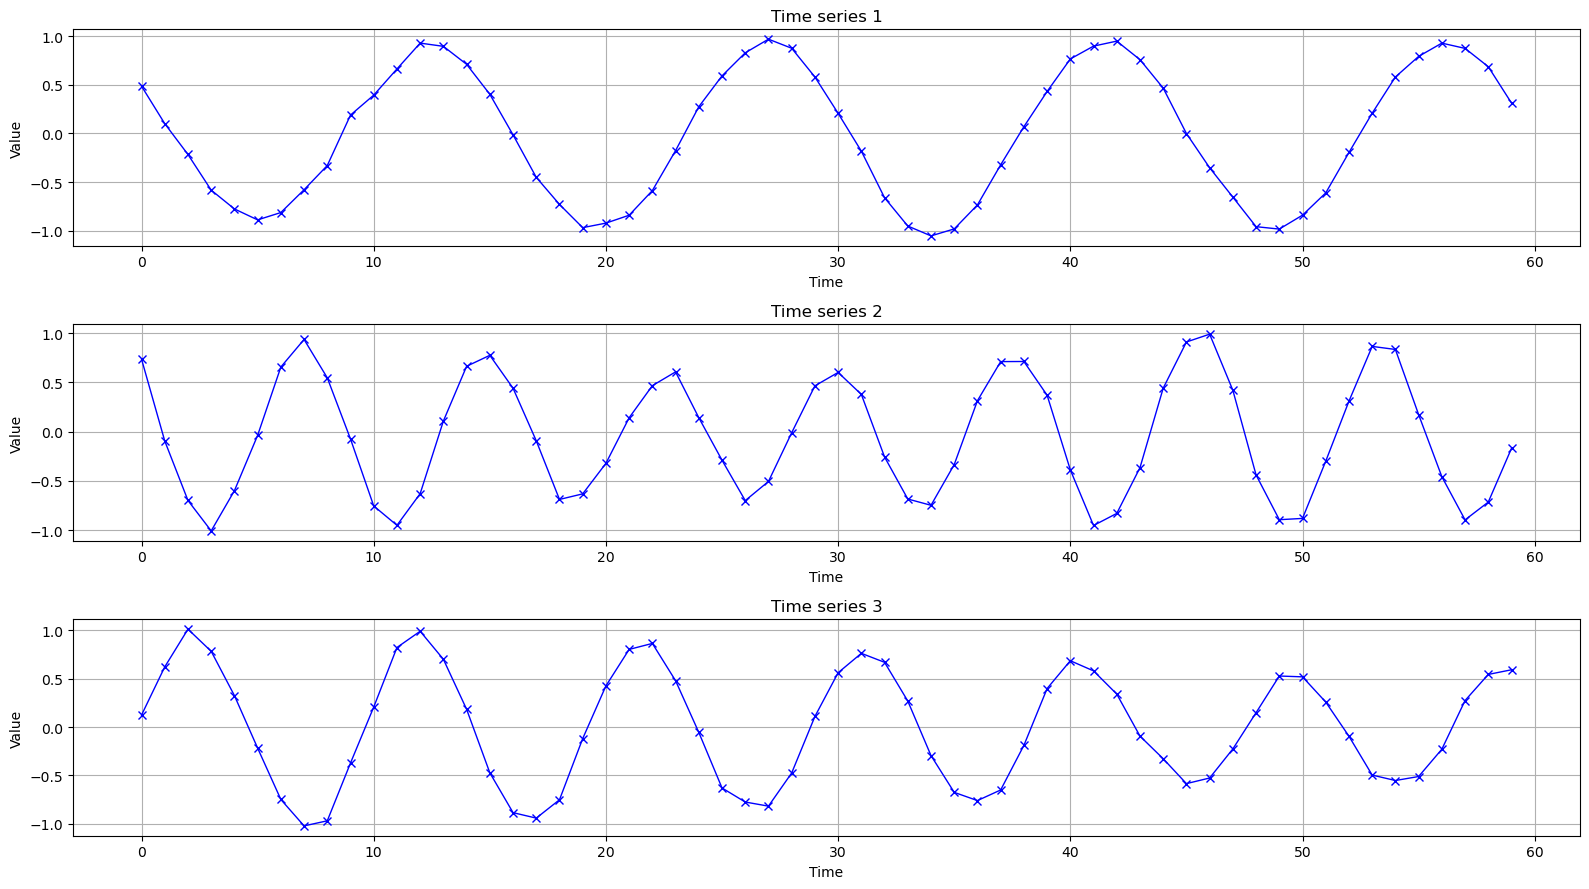

In [16]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [17]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 50)
y_train shape: (80, 10)
X_valid shape: (20, 50)
y_valid shape: (20, 10)


In [18]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16   # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline : RNN

In [19]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [20]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [21]:
# Test dimensions

x = torch.randn(BATCH_SIZE, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([16, 50, 1])
output shape: torch.Size([16, 10, 1])


In [22]:
def loss_rnn(y, y_hat):
    """
    Compute the loss for the RNN model.
    
    Args:
        y: target values - shape is (seq_len, batch_size, output_dim)
        y_hat: predicted values - shape is (seq_len, batch_size, output_dim)
    Returns:
        loss: MSE loss
    """
    
    seq_len = y.shape[0]
    batch_size = y.shape[1]
    output_dim = y.shape[2]
    
    # compute the loss
    loss = (y - y_hat)**2
    # print(loss.shape)
    loss = torch.sum(loss, dim=2)  # Sum over the output dimension
    loss = torch.sum(loss, dim=0)  # Sum over the sequence length
    loss = torch.sqrt(loss)  # Square root of the sum
    loss = torch.mean(loss)  # Mean over the batch
    loss = loss / seq_len
    
    return loss

criterion = nn.MSELoss()
# criterion = loss_rnn

In [23]:
lr = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
num_epochs = 100

In [24]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, n_ahead, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, n_ahead, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    if (i+1) % 10 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 100 epochs
epoch   10/100, training loss = 2.9384e-01, validation loss = 3.9698e-01
epoch   20/100, training loss = 2.5373e-01, validation loss = 2.7166e-01
epoch   30/100, training loss = 1.9471e-01, validation loss = 2.0632e-01
epoch   40/100, training loss = 1.7802e-01, validation loss = 2.0964e-01
epoch   50/100, training loss = 1.2565e-01, validation loss = 1.5961e-01
epoch   60/100, training loss = 1.1439e-01, validation loss = 1.4013e-01
epoch   70/100, training loss = 9.3637e-02, validation loss = 1.8112e-01
epoch   80/100, training loss = 7.9964e-02, validation loss = 1.1323e-01
epoch   90/100, training loss = 5.6991e-02, validation loss = 8.7110e-02
epoch  100/100, training loss = 7.3400e-02, validation loss = 7.2489e-02


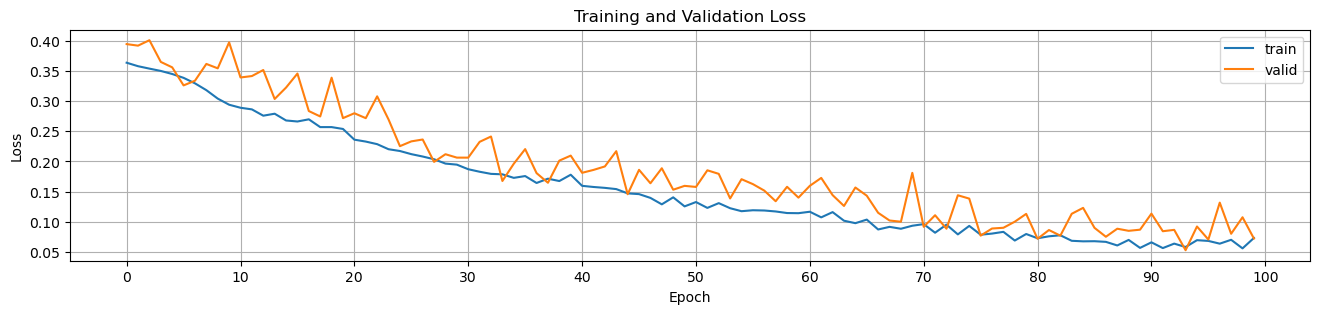

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 10))
ax.set_xticklabels(np.arange(0, num_epochs+1, 10))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [26]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

# print(f"y_target shape: {y_target.shape}")
# print(f"y_pred shape: {y_pred.shape}")

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_target - y_pred) ** 2)):.4f} RMSE")

Loss finale = 7.9518e-02


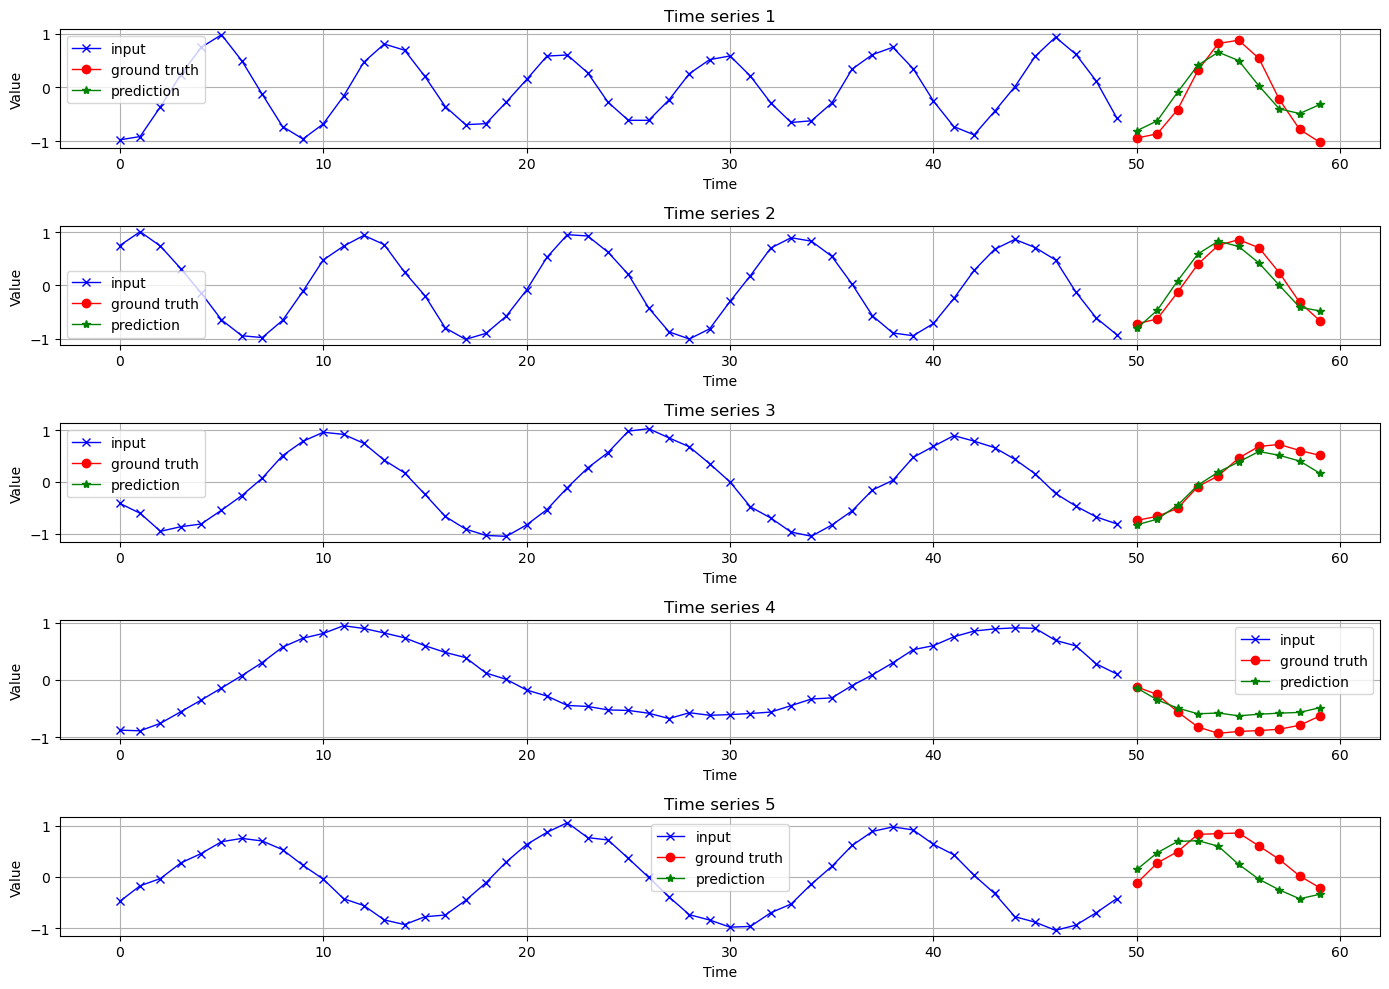

In [27]:
N = 5
fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
x_shift = X_valid.shape[-1]

for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
    # input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
    # target = target.permute(1, 0, 2)  # permute to (seq_len, batch_size, output_dim)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Training DKF - XP 1

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/DKF_Training.png" width="1500"/>
</div>

In [28]:
def train_step(model, optimizer, criterion, train_loader=train_loader, device=device, beta=None, K=None):
    ### training step
    model.train()
    optimizer.zero_grad()
    ### loop on training data
    rec_loss = 0
    kl_loss = 0
    epoch_loss = 0
    ### check on K
    if K is None:
        K=1
        
    x_dim = model.input_dim
    latent_dim = model.latent_dim
    
    for input, _ in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

        
        mu_x_t = torch.zeros(input.shape[0], input.shape[1], x_dim, K).to(device)
        logvar_x_t = torch.zeros(input.shape[0], input.shape[1], x_dim, K).to(device)
        mu_phi_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)
        logvar_phi_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)
        mu_theta_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)
        logvar_theta_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)

        # get K samples of the parameters of each distribution
        for k in range(K):
            # get the parameters of the distributions
            _, mu_x_t[:, :, :, k], logvar_x_t[:, :, :, k], mu_phi_z_t[:, :, :, k], logvar_phi_z_t[:, :, :, k], mu_theta_z_t[:, :, :, k], logvar_theta_z_t[:, :, :, k] = model(input)
        
        rec_loss, kl_loss, total_loss = criterion(input, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t, beta=beta)
        
        total_loss.backward()
        optimizer.step()
              
        rec_loss += rec_loss.item()
        kl_loss += kl_loss.item()
        epoch_loss += total_loss.item()
        
    epoch_loss /= len(train_loader)
    rec_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [29]:
# Test step : perform validation test for one epoch

def test_step(model, optimizer, loss_fn, test_loader=test_loader, device=device, beta=None):
    ### test step
    model.eval()
    
    with torch.no_grad():
        ### loop on test data
        rec_loss = 0
        kl_loss = 0
        epoch_loss = 0
        
        for input, _ in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

            _, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s = model(input)
            
            rec_loss, kl_loss, total_loss = loss_fn(input, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s, beta=beta)
                
            rec_loss += rec_loss.item()
            kl_loss += kl_loss.item()
            epoch_loss += total_loss.item()
            
        epoch_loss /= len(train_loader)
        rec_loss /= len(train_loader)
        kl_loss /= len(train_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [30]:
def train(model, optimizer, loss_fn, num_epochs=100, beta=None, beta_scheduler=None, display_frequency=10, K=None):
    
    rec_losses = []
    kl_losses = []
    epoch_losses = []

    val_rec_losses = []
    val_kl_losses = []
    val_epoch_losses = []
    
    if K is None:
        K = 1

    for i in range(num_epochs):
        
        # use the beat scheduler if provided
        if beta_scheduler is not None:
            beta = beta_scheduler(i)
        
        # run the training step
        rec_loss, kl_loss, epoch_loss = train_step(model, optimizer, loss_fn, beta=beta, K=K)
        # log results
        rec_losses.append(rec_loss)
        kl_losses.append(kl_loss)
        epoch_losses.append(epoch_loss)
        
        # run test step
        val_rec_loss, val_kl_loss, val_epoch_loss = test_step(model, optimizer, loss_fn, beta=beta)
        # log results
        val_rec_losses.append(val_rec_loss)
        val_kl_losses.append(val_kl_loss)
        val_epoch_losses.append(val_epoch_loss)
        
        # Print the losses for this epoch
        if (i+1) % display_frequency == 0:
            print(f"Epoch {i+1:>5}/{num_epochs} with beta = {beta:.2e} - TRAINING : Rec Loss: {rec_loss:.4e}, KL Loss: {kl_loss:.4e}, Total Loss: {epoch_loss:.4e} - TEST : Rec Loss: {val_rec_loss:.4e}, KL Loss: {val_kl_loss:.4e}, Total Loss: {val_epoch_loss:.4e}")
            
    return rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses        

In [31]:
xdim = 1
latent_dim = 2
h_dim = 16
combiner_dim = 2
num_layers_rnn = 2

In [32]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=2, hidden_dim=16, combiner_dim=2, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 16, num_layers=2)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)
DecoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_

In [33]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-4)
loss_fn = loss_function
beta = 1e-3

K = 3

In [34]:
num_epochs = 500
n_displays = 20
display_frequency = int(num_epochs / n_displays)

In [35]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
    dkf, optimizer, loss_fn, num_epochs=num_epochs, beta=beta, display_frequency=display_frequency, K=K
)

Epoch    25/500 with beta = 1.00e-03 - TRAINING : Rec Loss: 4.4012e-02, KL Loss: 4.1513e-01, Total Loss: 1.1069e-01 - TEST : Rec Loss: 3.6756e-02, KL Loss: 4.1365e-01, Total Loss: 4.5929e-02
Epoch    50/500 with beta = 1.00e-03 - TRAINING : Rec Loss: 2.3125e-02, KL Loss: 4.2822e-01, Total Loss: 6.9887e-02 - TEST : Rec Loss: 3.3663e-02, KL Loss: 4.2761e-01, Total Loss: 3.4450e-02
Epoch    75/500 with beta = 1.00e-03 - TRAINING : Rec Loss: 1.2339e-02, KL Loss: 4.6505e-01, Total Loss: 3.9564e-02 - TEST : Rec Loss: 2.2777e-02, KL Loss: 4.6327e-01, Total Loss: 2.2897e-02
Epoch   100/500 with beta = 1.00e-03 - TRAINING : Rec Loss: 6.0815e-03, KL Loss: 4.8183e-01, Total Loss: 2.9513e-02 - TEST : Rec Loss: 2.1642e-02, KL Loss: 4.8064e-01, Total Loss: 2.1905e-02
Epoch   125/500 with beta = 1.00e-03 - TRAINING : Rec Loss: -3.0256e-04, KL Loss: 4.7185e-01, Total Loss: 2.5972e-02 - TEST : Rec Loss: 4.6712e-02, KL Loss: 4.7192e-01, Total Loss: 2.9737e-02
Epoch   150/500 with beta = 1.00e-03 - TRAIN

In [36]:
def plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses):
    
    # Plot the losses

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))

    axs[0].plot(torch.tensor(rec_losses).cpu().detach(), label='Training', color='blue')
    axs[0].plot(torch.tensor(val_rec_losses).cpu().detach(), label='Test', color='green')
    axs[0].set_title('Reconstruction Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(torch.tensor(kl_losses).cpu().detach(), label='Training', color='blue')
    axs[1].plot(torch.tensor(val_kl_losses).cpu().detach(), label='Test', color='green')
    axs[1].set_title('KL Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(torch.tensor(epoch_losses).cpu().detach(), label='Training', color='blue')
    axs[2].plot(torch.tensor(val_epoch_losses).cpu().detach(), label='Test', color='green')
    axs[2].set_title('Total Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')
    axs[2].legend()
    axs[2].grid()

    plt.tight_layout()
    plt.show()

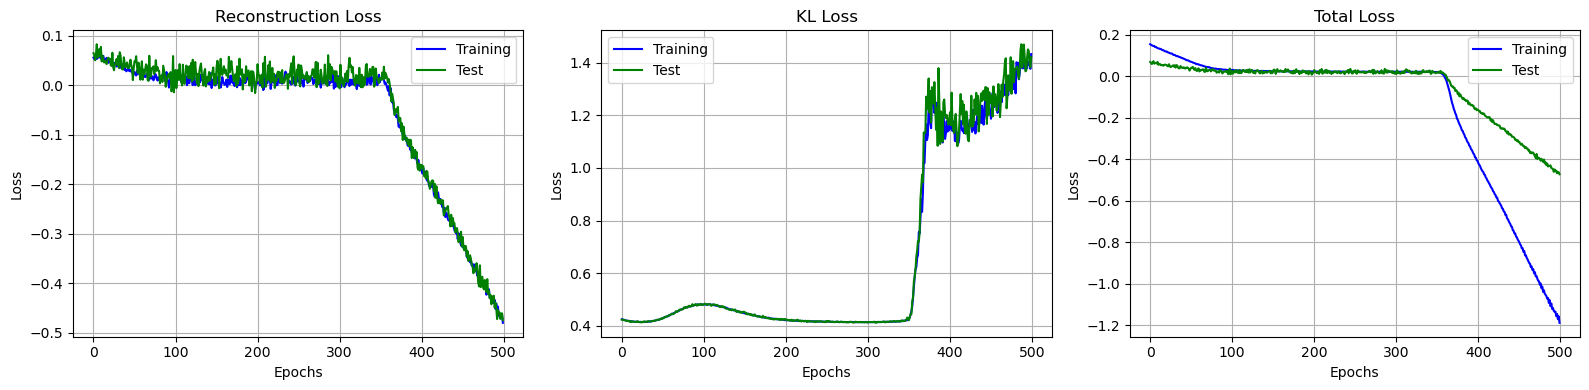

In [37]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

# Predictions

In [38]:
def sample_predictions(N_SAMPLES=3, model=dkf):
    
    idx = np.random.randint(0, len(X_valid), N_SAMPLES)
    X_valid_subset = X_valid[idx]
    y_valid_subset = y_valid[idx]
    
    fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 3 * N_SAMPLES))
    for i in range(N_SAMPLES):
        input = torch.tensor(X_valid_subset[i], device=device).unsqueeze(1).unsqueeze(2)
        # print(f"input shape : {input.shape}")
        target = torch.tensor(y_valid_subset[i], device=device)
        target = target.cpu().detach().numpy()
        mu_predictions, logvar_predictions, mu_full_x, logvar_full_x = model.predict(input, n_ahead)
              
        # display data
        axs[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
        axs[i].plot(np.arange(len(target))+n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
        
        # display predictions and credible intervals
        all_times = np.arange(n_steps+n_ahead)
        mu_full_x = mu_full_x.squeeze().cpu().detach().numpy()
        logvar_full_x = logvar_full_x.squeeze().cpu().detach().numpy()
        std_full_x = np.exp(logvar_full_x / 2)
        
        axs[i].scatter(all_times, mu_full_x, color='green', marker="*", linewidth=1, label="reconstructed and predicted")
        axs[i].fill_between(all_times, mu_full_x-2*std_full_x, mu_full_x+2*std_full_x, color='orange', label='+/- 2 std', alpha=0.2)
        
        axs[i].set_title(f"Time series {idx[i]}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")
        axs[i].legend()
        axs[i].grid(True)
        
    plt.tight_layout()
    plt.show()

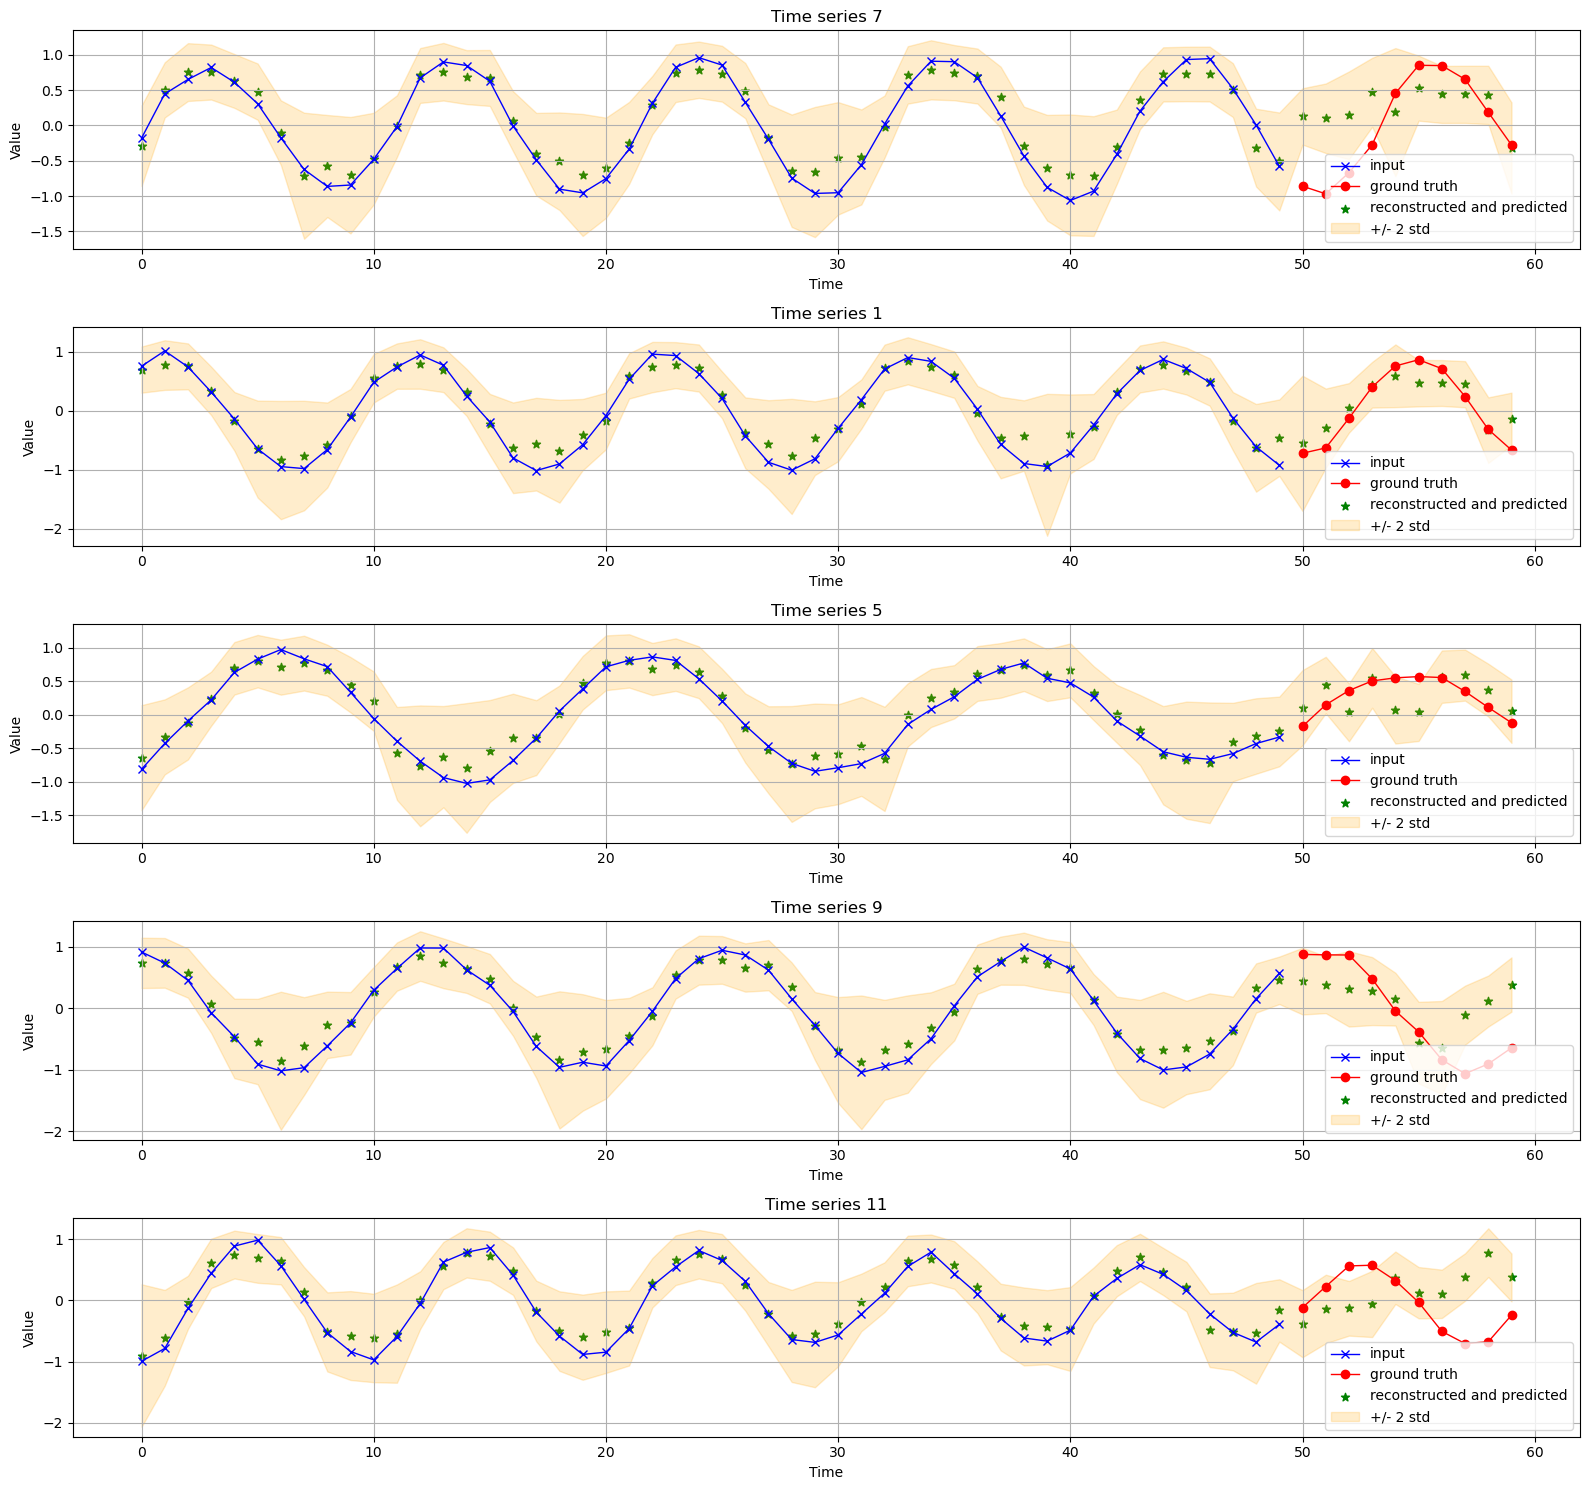

In [39]:
sample_predictions(N_SAMPLES=5, model=dkf)

# XP 2

$\beta = 1.0$, n_epochs = 500

In [40]:
xdim = 1
latent_dim = 2
h_dim = 16
combiner_dim = 2
num_layers_rnn = 2

In [41]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=2, hidden_dim=16, combiner_dim=2, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 16, num_layers=2)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)
DecoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=2, out_

In [42]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-4)
loss_fn = loss_function
beta = 1.0

K = 3

In [43]:
num_epochs = 1000
n_displays = 25
display_frequency = int(num_epochs / n_displays)

In [44]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
    dkf, optimizer, loss_fn, num_epochs=num_epochs, beta=beta, display_frequency=display_frequency, K=K
)

Epoch    40/1000 with beta = 1.00e+00 - TRAINING : Rec Loss: 6.2399e-02, KL Loss: 4.1424e-01, Total Loss: 1.1837e+00 - TEST : Rec Loss: 8.3613e-02, KL Loss: 4.1438e-01, Total Loss: 4.8486e-01
Epoch    80/1000 with beta = 1.00e+00 - TRAINING : Rec Loss: 4.4884e-02, KL Loss: 4.0553e-01, Total Loss: 1.1169e+00 - TEST : Rec Loss: 4.4040e-02, KL Loss: 4.0476e-01, Total Loss: 4.5101e-01
Epoch   120/1000 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.2071e-02, KL Loss: 4.0195e-01, Total Loss: 1.0784e+00 - TEST : Rec Loss: 1.9930e-02, KL Loss: 4.0198e-01, Total Loss: 4.3228e-01
Epoch   160/1000 with beta = 1.00e+00 - TRAINING : Rec Loss: 2.9278e-02, KL Loss: 4.0125e-01, Total Loss: 1.0571e+00 - TEST : Rec Loss: 2.3676e-02, KL Loss: 4.0125e-01, Total Loss: 4.2882e-01
Epoch   200/1000 with beta = 1.00e+00 - TRAINING : Rec Loss: 1.5569e-02, KL Loss: 4.0113e-01, Total Loss: 1.0445e+00 - TEST : Rec Loss: 3.5007e-02, KL Loss: 4.0096e-01, Total Loss: 4.3106e-01
Epoch   240/1000 with beta = 1.00e+00 - 

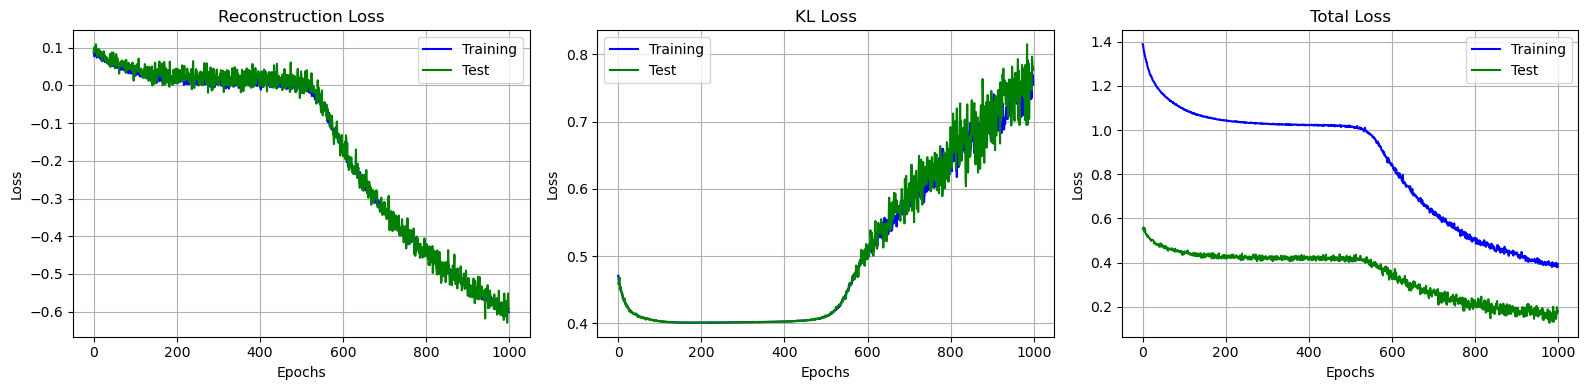

In [45]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

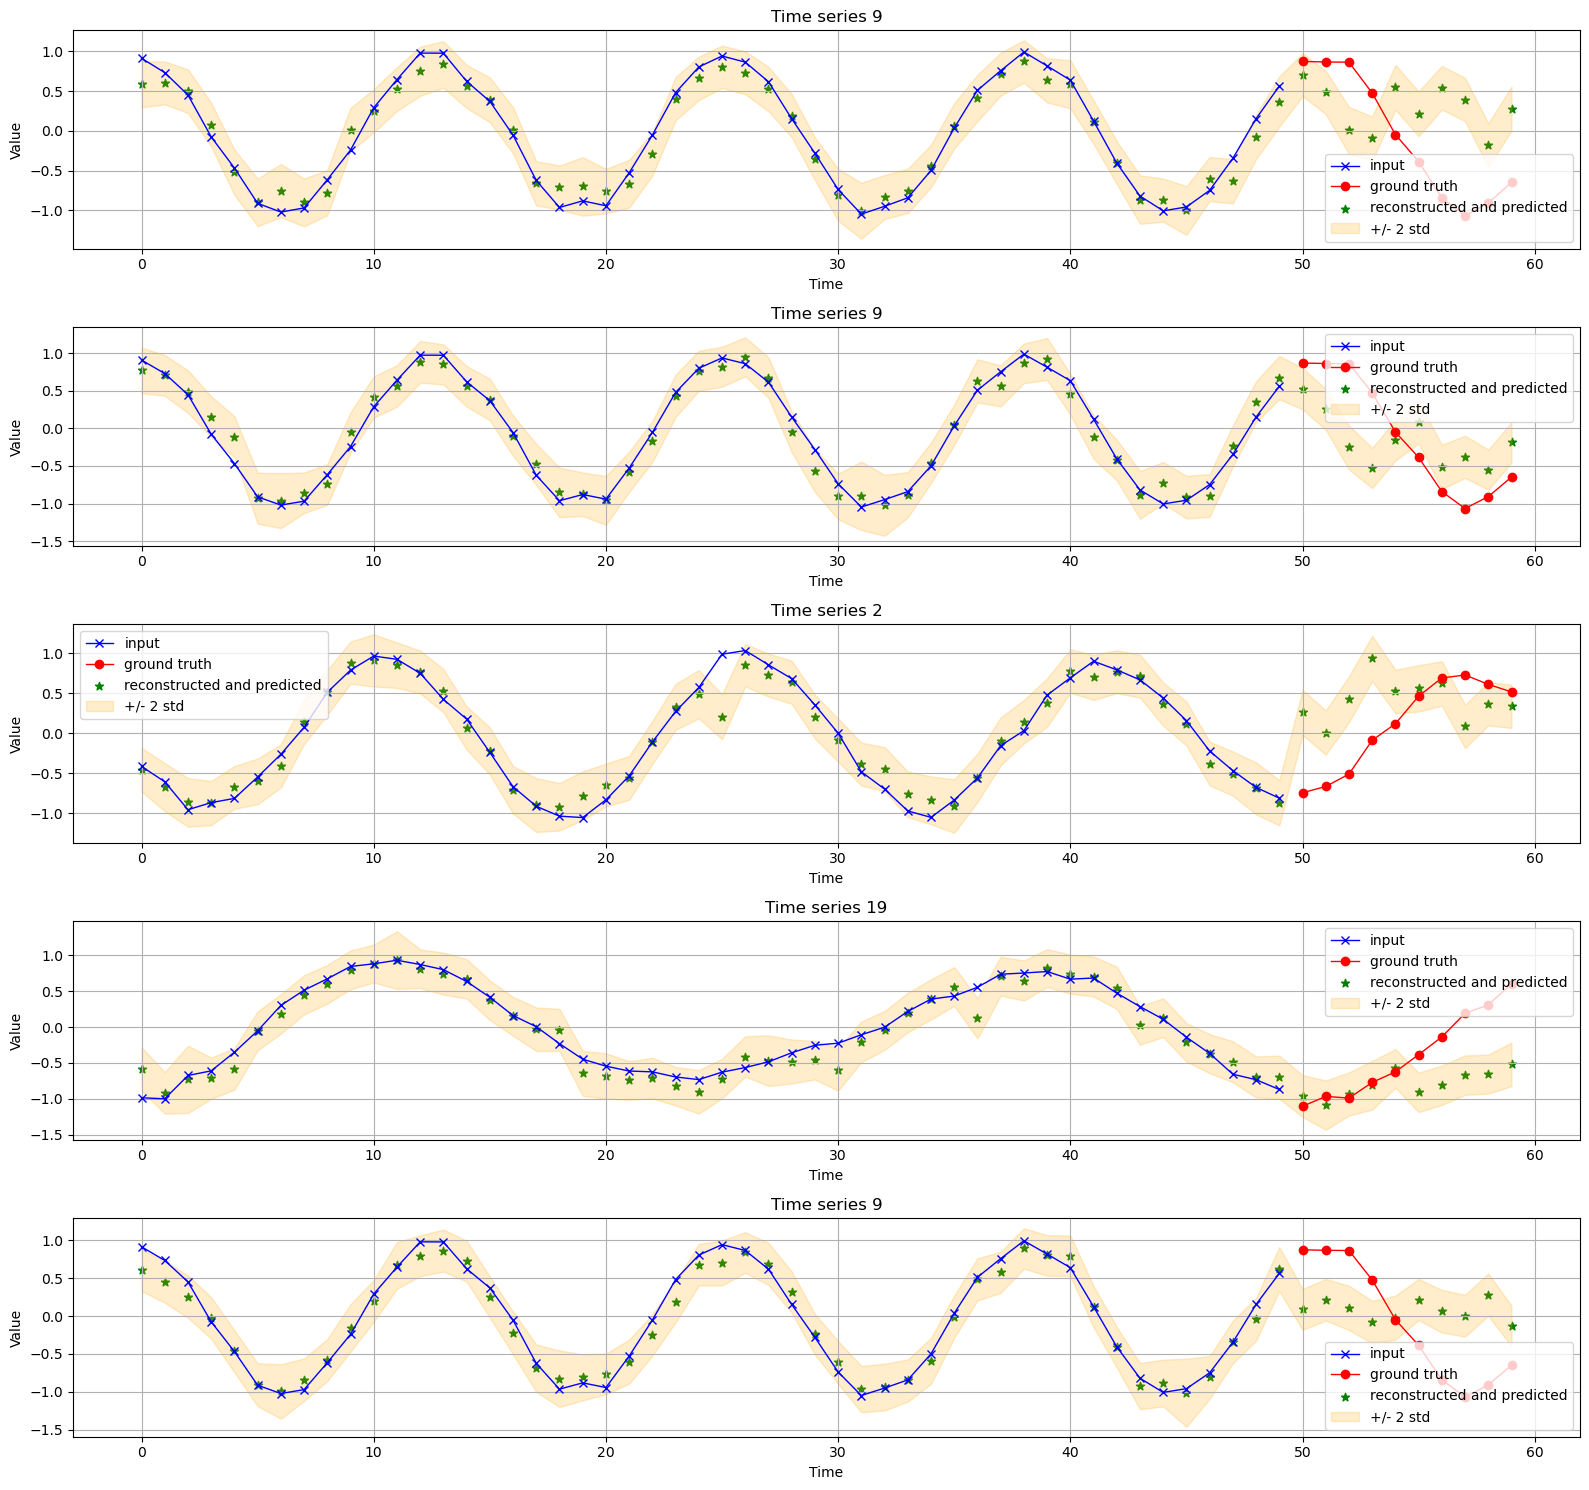

In [46]:
sample_predictions(N_SAMPLES=5, model=dkf)

# XP 3

Réseau plus expressif, $\beta = 1.0$, 500 epochs, K=10

In [47]:
xdim = 1
latent_dim = 8
h_dim = 32
combiner_dim = 4
num_layers_rnn = 4

In [48]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=8, hidden_dim=32, combiner_dim=4, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 32, num_layers=4)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=40, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=16, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
  )
)
DecoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=8, ou

In [49]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-4)
loss_fn = loss_function
beta = 1.0

K = 10

In [50]:
num_epochs = 500
n_displays = 25
display_frequency = int(num_epochs / n_displays)

In [51]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
    dkf, optimizer, loss_fn, num_epochs=num_epochs, beta=beta, display_frequency=display_frequency, K=K
)

Epoch    20/500 with beta = 1.00e+00 - TRAINING : Rec Loss: 1.0316e-01, KL Loss: 1.7979e+00, Total Loss: 4.7527e+00 - TEST : Rec Loss: 1.0732e-01, KL Loss: 1.7918e+00, Total Loss: 1.8995e+00
Epoch    40/500 with beta = 1.00e+00 - TRAINING : Rec Loss: 8.8135e-02, KL Loss: 1.7241e+00, Total Loss: 4.5391e+00 - TEST : Rec Loss: 9.1498e-02, KL Loss: 1.7221e+00, Total Loss: 1.8139e+00
Epoch    60/500 with beta = 1.00e+00 - TRAINING : Rec Loss: 8.0359e-02, KL Loss: 1.6764e+00, Total Loss: 4.3964e+00 - TEST : Rec Loss: 8.4591e-02, KL Loss: 1.6766e+00, Total Loss: 1.7599e+00
Epoch    80/500 with beta = 1.00e+00 - TRAINING : Rec Loss: 7.4111e-02, KL Loss: 1.6519e+00, Total Loss: 4.3155e+00 - TEST : Rec Loss: 8.3267e-02, KL Loss: 1.6536e+00, Total Loss: 1.7335e+00
Epoch   100/500 with beta = 1.00e+00 - TRAINING : Rec Loss: 6.8016e-02, KL Loss: 1.6378e+00, Total Loss: 4.2586e+00 - TEST : Rec Loss: 6.8966e-02, KL Loss: 1.6387e+00, Total Loss: 1.7083e+00
Epoch   120/500 with beta = 1.00e+00 - TRAINI

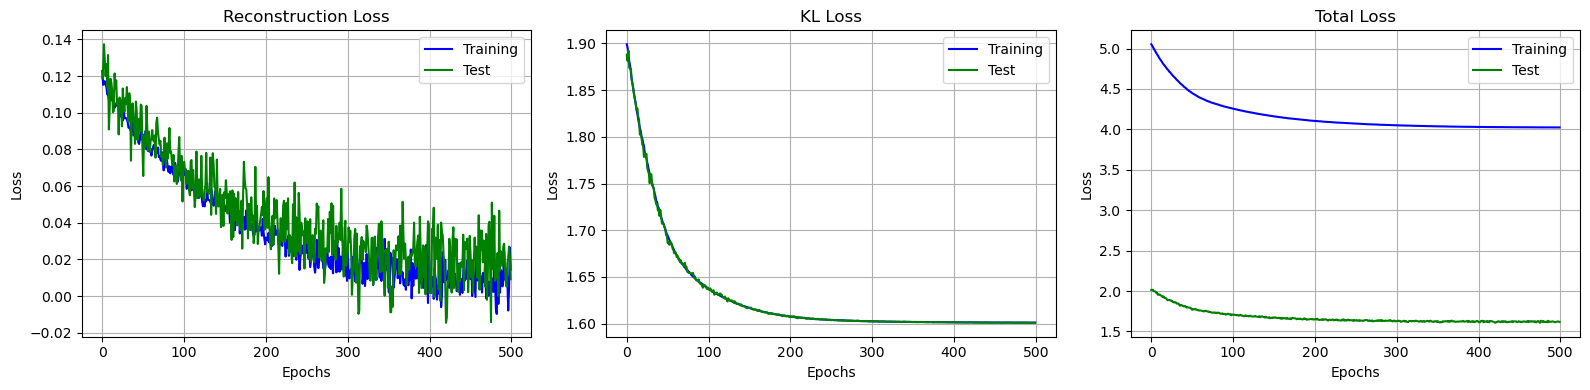

In [52]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

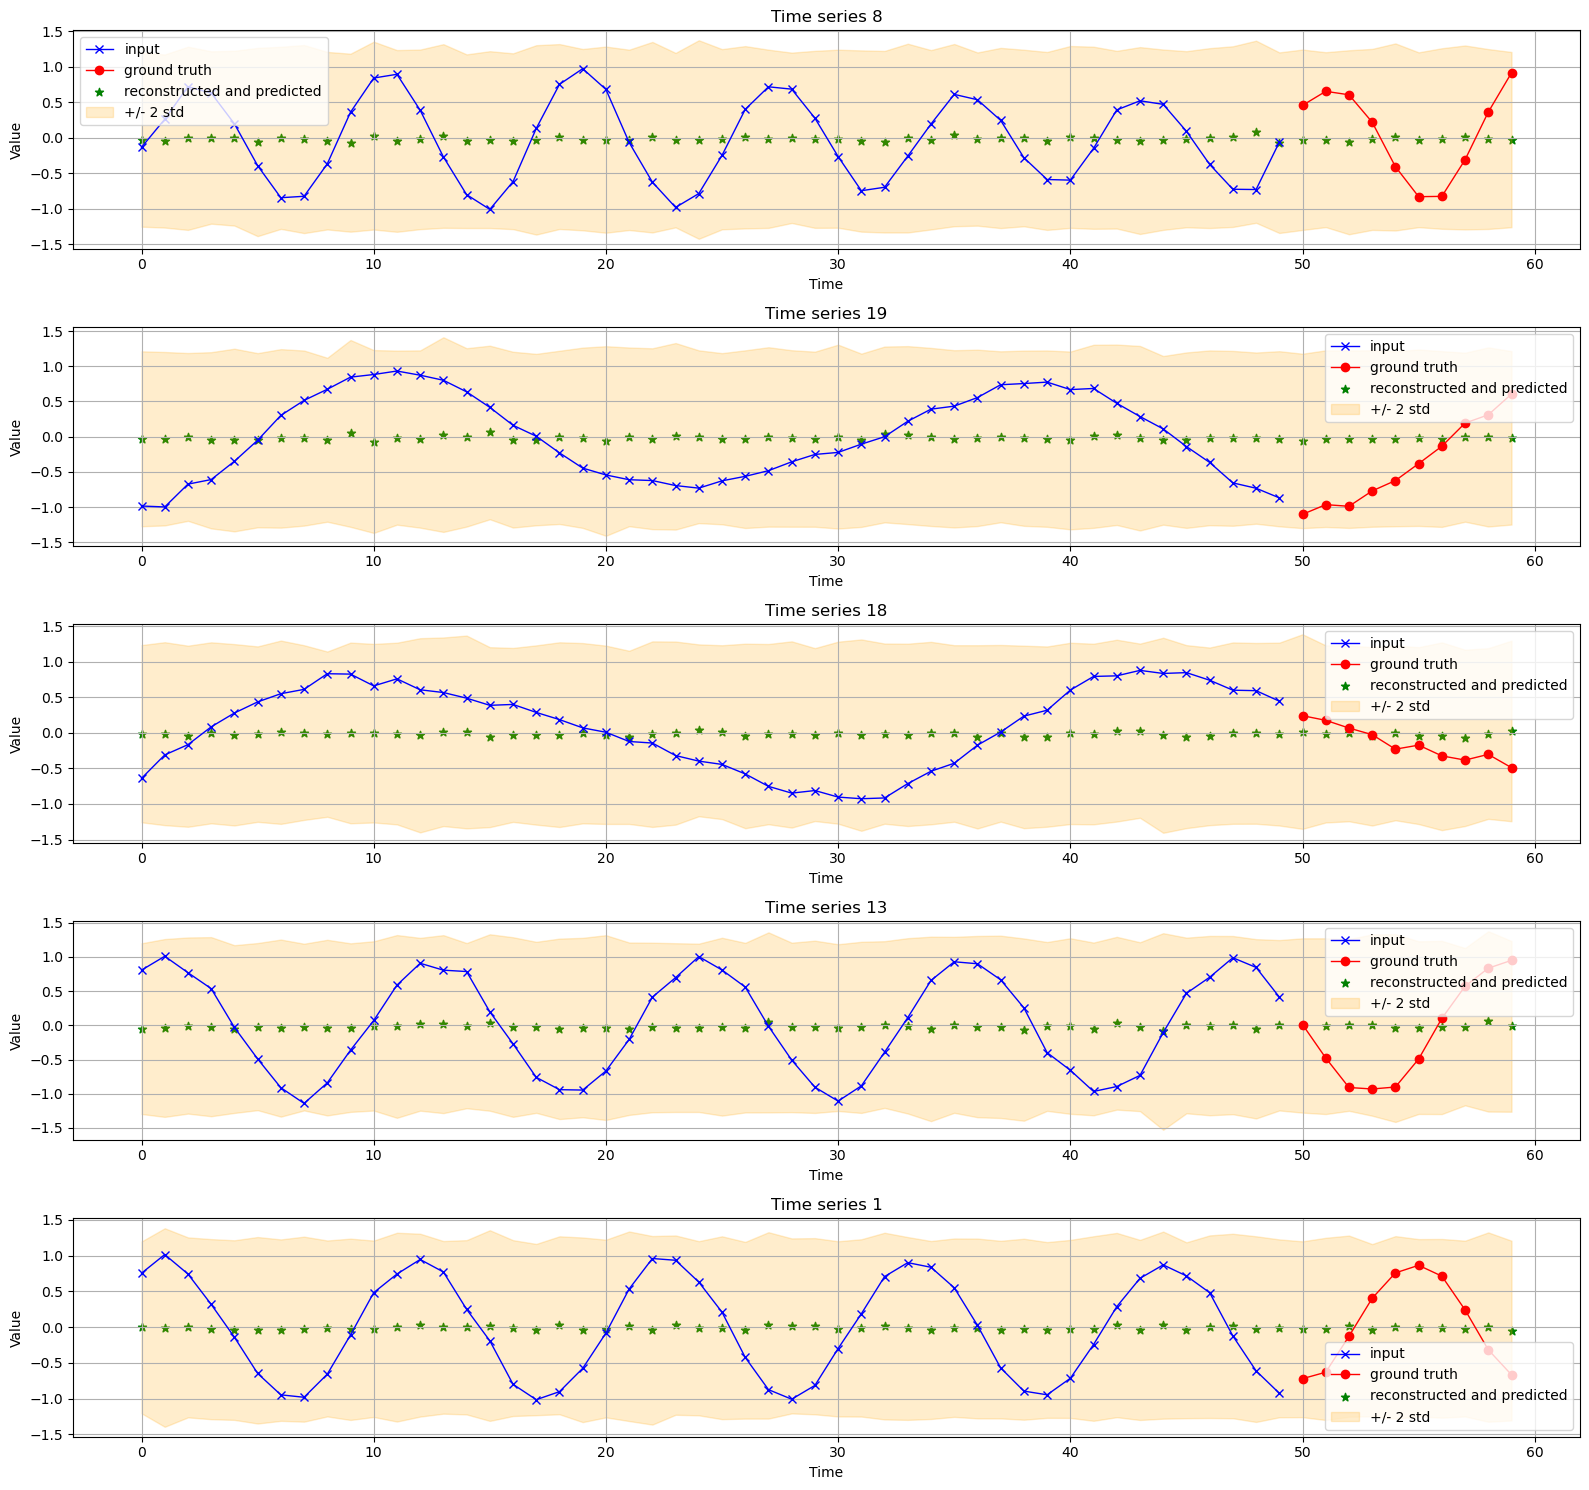

In [53]:
sample_predictions(N_SAMPLES=5, model=dkf)

# Commentaires à ce stade :

~~C1 - REVOIR LE TRAINING ! cf https://dynamicalvae.github.io/tuto_icassp2021/DVAE_tutorial.html (slide training DKF)~~

Q1 - L'ELBO contient une expectation de KLs entre les vraies posterieures et les approximées. Une méthode est mentionnée p64 du papier de l'INRIA. 

#### Mon codage de la loss est-il correct ?

Q2 - A priori plus de problème de stabilité ? Mais on constate un changement de régime pendant le training. Est-ce que cela correspond à un maximum d'expressivité du modèle ? Ou autre chose (ie $\sigma_{\theta_x} \longrightarrow 0$?)

Q3 - Je calcule la prédiction en utilisant la moyenne de $p_{\theta_z}$ plutôt que celle de $q_\phi$ ... Mais ça se discute ?

Q4 - Comment arbitrer entre la KL et la reconstruction ? Piste 1 : faire un scheduler sur $\beta$ ? (cf papiers plus bas)

Q5 - Choix des différents paramètres ? Grid-search ? Early stopping + train till end of patience ? Autre ?

Q6 - Influence de K ? (nombre de samples pour calculer les expectations dans la loss)

Q7 - Architecture des réseaux : drop outs ? batch norms ? softplus pour sortir var plutôt qu'une linéaire pour sortir logvar ?

Articles sur le sujet (biblio papier INRIA):
- https://arxiv.org/pdf/1602.02282 (Ladder VAE)
- https://arxiv.org/pdf/2007.03898 (NVAE: A Deep Hierarchical Variational Autoencoder)
  
Tuto (slides extrêmement bien faites):
- https://dynamicalvae.github.io/tuto_icassp2021/DVAE_tutorial.html


## Piste 1 : Implementing a simple linear Beta scheduler

In [54]:
class BetaLinearScheduler():
    """Scheduler linéaire simple du beta, rapport entre la loss de reconstruction et la loss KL
    """
    
    def __init__(self, beta_start=0.0, beta_end=1.0, num_epochs=100):
        """Constructeur

        Args:
            beta_start (float, optional): coefficient beta au démarrage. Defaults to 0.0.
            beta_end (float, optional): coefficient beta en fin de schedule. Defaults to 1.0.
            num_epochs (int, optional): nombre d'epochs sur lequel se fait l'évolution du beta. Defaults to 100.
        """
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.num_epochs = num_epochs
        
    def __call__(self, epoch):
        """Calcul du beta à l'epoch donnée

        Args:
            epoch (int): epoch courante

        Returns:
            float: beta
        """
        
        return self.beta_start + (self.beta_end - self.beta_start) * (np.min([epoch, self.num_epochs]) / self.num_epochs)

In [55]:
# dkf = DeepKalmanFilter(
#     input_dim = xdim,
#     latent_dim = latent_dim,
#     hidden_dim = h_dim,
#     combiner_dim = combiner_dim,
#     num_layers = num_layers_rnn,
#     device=device
# ).to(device)

# print(dkf)

In [56]:
# optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
# loss_fn = loss_function

# num_epochs = 250
# n_displays = 20  # nombre d'affichages souhaités
# display_frequency = int(num_epochs / n_displays)

# beta_scheduler = BetaLinearScheduler(beta_start=0.0, beta_end=1.0, num_epochs=50)  # warm up beta

In [57]:
# rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
#     dkf, optimizer, loss_fn, num_epochs=num_epochs, beta_scheduler=beta_scheduler, display_frequency=display_frequency
# )

In [58]:
# plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

In [59]:
# sample_predictions(N_SAMPLES=5, model=dkf)